In [1]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

In [3]:
folder_path = os.path.join('..', '..', '..', 'data/yelp_data', 'fake_task')
train =  pd.read_csv(os.path.join(folder_path, 'train.csv'))
valid = pd.read_csv(os.path.join(folder_path, 'valid.csv'))
test = pd.read_csv(os.path.join(folder_path, 'test.csv'))

In [4]:
train = train.append(valid).reset_index(drop=True)
train.shape

(13784, 2)

In [5]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


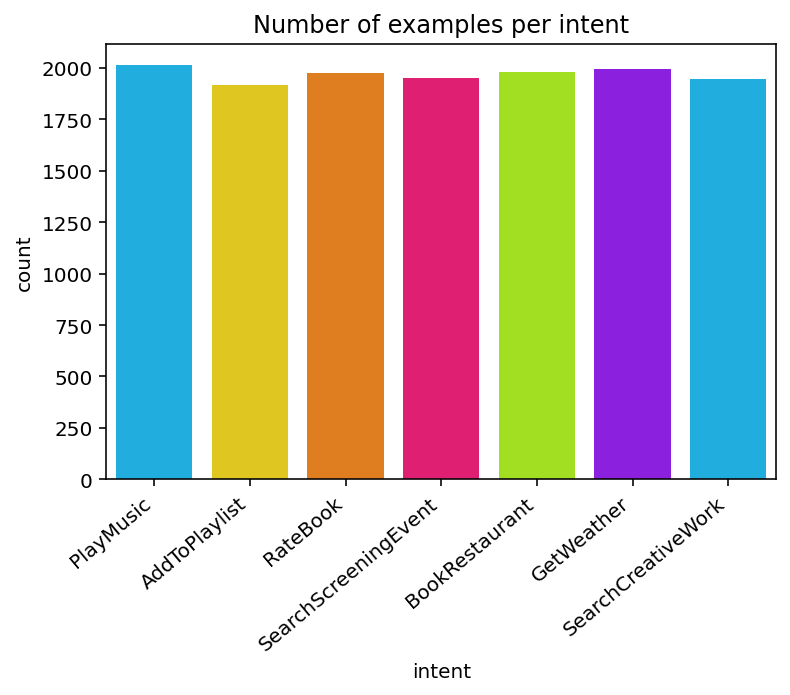

In [6]:
chart = sns.countplot(train.intent, palette= HAPPY_COLORS_PALETTE)
plt.title('Number of examples per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=40, horizontalalignment='right');

In [ ]:
folder_path = os.path.join('..', '..', '..', 'data/uncased_L-12_H-768_A-12')

In [ ]:
bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

In [ ]:
class IntentDetection:
    DATA_COLUMN = 'text'
    LABALE_COLUMN = 'intent'
    
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.classes = classes
        self.max_seq_len = 0
        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
        
    def _prepare(self, df):
        x, y = [], []
        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetection.DATA_COLUMN], row[IntentDetection.LABALE_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            
            x.append(token_ids)
            y.append(self.classes.index(label))
        return np.array(x), np.array(y)
    
    def _pad(self, ids):
        x = []
        for input_ids in ids:
            cut_point = min(len(input_ids), self.max_seq_len - 2)
            input_ids = input_ids[:cut_point]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.asarray(input_ids))
        return np.array(x)

In [ ]:
folder_path = os.path.join('..', '..', '..', 'data/model/uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

In [ ]:
tokens = tokenizer.tokenize('I work at 4343!!Google!!!')
tokens

In [ ]:
tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):
#     with tf.io.gfile.GFile(bert_config_file, 'r') as gf:
#         bc = StockBertConfig.from_json_string(gf.read())
#         bert_params = map_stock_config_to_params(bc)
#         bert_params.adapter_size = None
#         bert = BertModelLayer.from_params(bert_params, name='bert')
        
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape) 
    
    # I still do not understand this line
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation='tanh')(cls_out)
    logits = keras.layers.Dense(units=len(classes), activation='softmax')(logits)
    
    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    
    # pre trained weights are loaded
    load_stock_weights(bert, bert_ckpt_file)
    
    return model

In [ ]:
classes = train.intent.unique().tolist()
classes

In [ ]:
test.head()

In [ ]:
data = IntentDetection(train, test, tokenizer, classes, max_seq_len=128)

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

In [ ]:
model.summary()

In [ ]:
data.train_x.shape

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')]
             )

In [ ]:
log_dir = os.path.join(folder_path, 'log', datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    x=data.train_x,
    y=data.train_y,
    validation_split=0.1,
    batch_size=128,
    shuffle=True,
    epochs=5
    #callbacks=[tensorboard_callback]
)

In [ ]:
_, test_acc = model.evaluate(data.test_x, data.test_y)
test_acc